# Implementation of Binary Logistic Regression using Tensorflow core

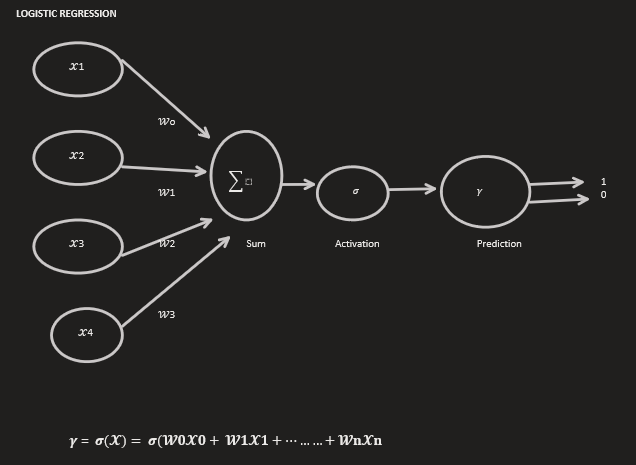

- In machine learning, binary logistic regression is a popular and fundamental classification algorithm used to solve binary classification problems. It is a supervised learning method, which means it requires labeled data during training to learn the relationship between the features (independent variables) and the binary outcome (dependent variable).

- In simple terms, binary logistic regression is a machine learning model used when you have data with two possible outcomes (categories or classes).

In this notebook we are going to implement binary logistic regression to classify the digits zeros and ones.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-07-21 21:26:19.878822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 21:26:19.924529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 21:26:19.926008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 21:26:20.673460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 58
tf.random.set_seed(SEED)

In [3]:
tf.random.normal((1,2))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5668071, 1.1792463]], dtype=float32)>

# Load the Data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
print("x_train shape: ",x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


In [6]:
NUM_CLASSES = len(np.unique(y_train))
print(f"There are {NUM_CLASSES} unique classes in this dataset")

There are 10 unique classes in this dataset


Let's extract the images from the dataset that contains zeros or ones.

In [7]:
class_label1 = 0  # digit zero
class_label2 = 1  # digit one
x_train_binary = x_train[(y_train == class_label1) | (y_train == class_label2)]
y_train_binary = y_train[(y_train == class_label1) | (y_train == class_label2)]

In [8]:
print("x_train shape: ",x_train_binary.shape)
print("y_train shape: ", y_train_binary.shape)

x_train shape:  (12665, 28, 28)
y_train shape:  (12665,)


In [9]:
CLASSES = np.unique(y_train_binary)
NUM_CLASSES = len(CLASSES)
print(f"There are {NUM_CLASSES} unique classes in this dataset and they are {CLASSES}")

There are 2 unique classes in this dataset and they are [0 1]


In [10]:
def show_data(index, x, y):
    plt.figure(figsize=(20,4))
    for i in range(index, index+5):
        img = x[i]
        label = y[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title('Training: %i\n' % label, fontsize = 15);

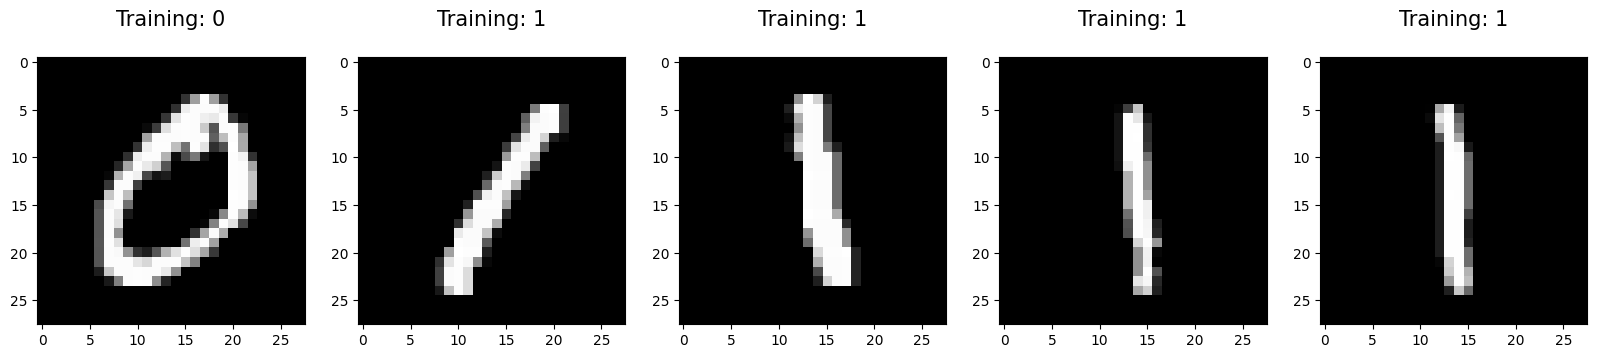

In [11]:
show_data(0, x_train_binary, y_train_binary)

In [12]:
x_train = x_train_binary
y_train = y_train_binary

# Preprocess the data

In [13]:
x_train = tf.reshape(x_train, shape=(x_train.shape[0], -1))
x_test = tf.reshape(x_test, shape=(x_test.shape[0], -1))

In [14]:
x_train.shape, x_test.shape

(TensorShape([12665, 784]), TensorShape([10000, 784]))

In [15]:
x_train = tf.cast(tf.transpose(x_train), "float32")
y_train = tf.constant(y_train)
print("New x_train shape: ", x_train.shape)

New x_train shape:  (784, 12665)


2023-07-21 21:26:22.756791: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39717440 exceeds 10% of free system memory.


In [16]:
# Normalization 
class Normalize(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    def norm(self, x):
        # normalize the input image
        return x / 255.
    def denorm(self, x):
        return x*255.

In [17]:
norm_x = Normalize()

In [18]:
x_train = norm_x.norm(x_train)

2023-07-21 21:26:22.788345: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39717440 exceeds 10% of free system memory.


In [19]:
tf.reduce_min(x_train).numpy(), tf.reduce_max(x_train).numpy()

(0.0, 1.0)

# Sigmoid Activation function

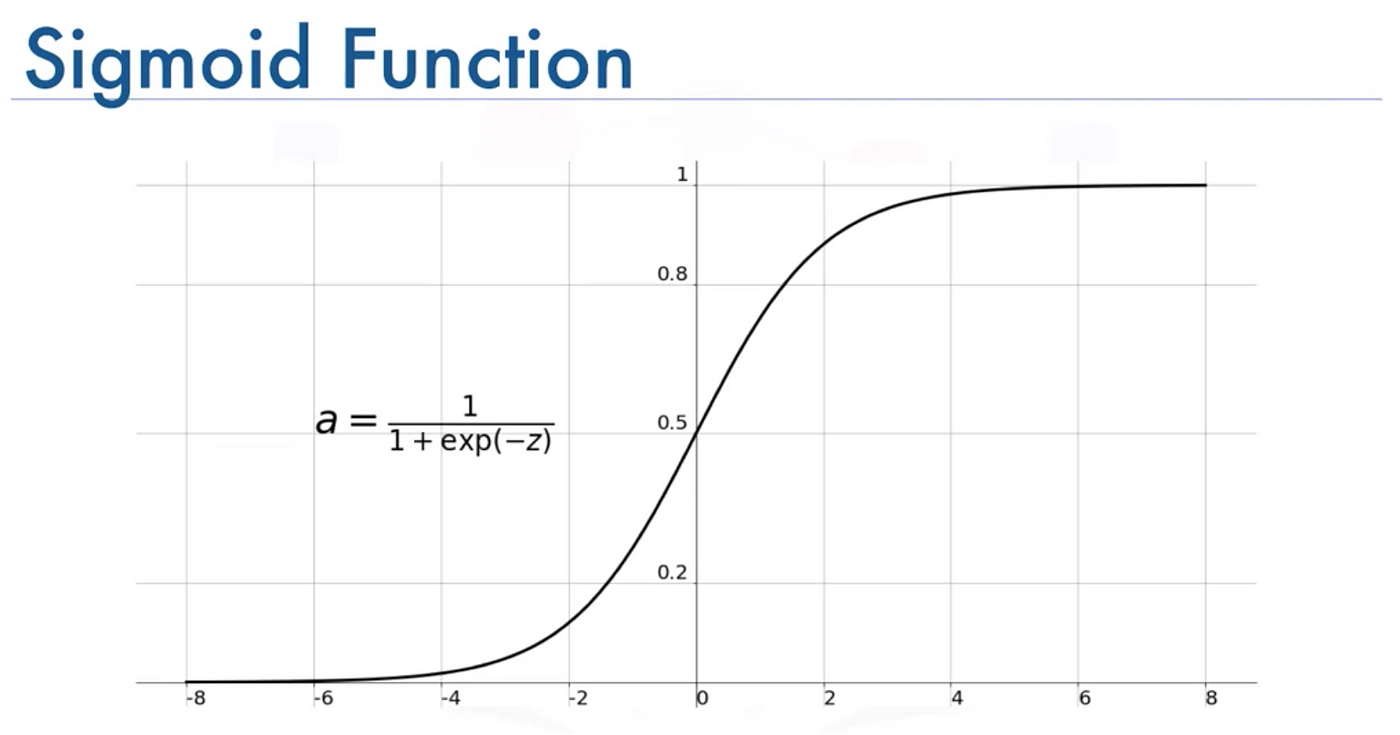

In [20]:
def sigmoid(z):
    exp_z = tf.math.exp(-z)
    return 1 / (1 + exp_z)

In [21]:
x = tf.constant([[0.9, 1.35, -1.3456],
                 [2.456, 3.987, 4.234]])

# for verification whether the sigmoid is working fine or not
print("output from our function: ", sigmoid(x).numpy())
print("output from built in sigmoid function: ", tf.math.sigmoid(x).numpy())

output from our function:  [[0.7109495  0.7941296  0.20659064]
 [0.9209991  0.98178273 0.98571277]]
output from built in sigmoid function:  [[0.7109495  0.7941296  0.20659065]
 [0.9209991  0.98178273 0.98571277]]


# Binary Cross Entropy loss function
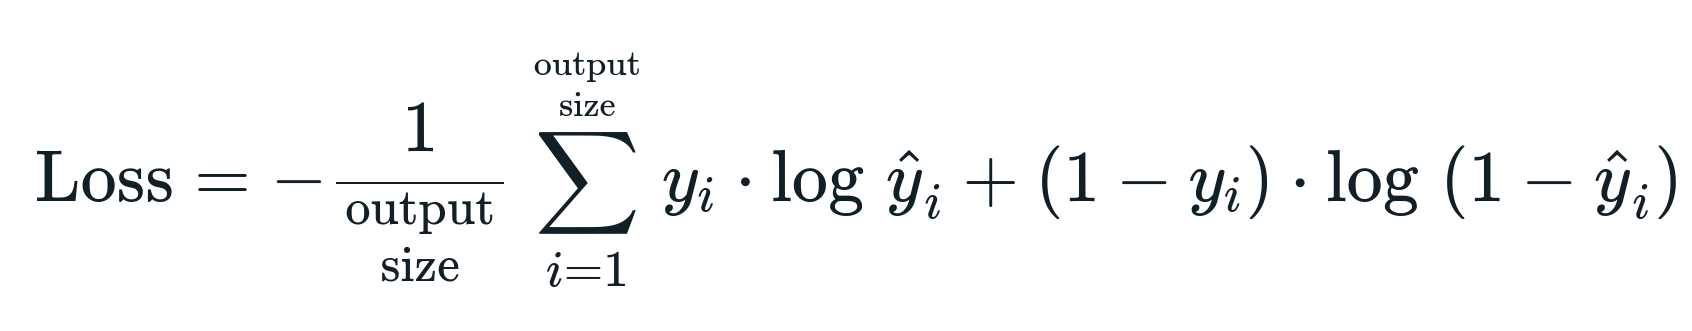

In [246]:
def binary_cross_entropy(y_true, y_pred, from_logits=False):
    y_true = tf.cast(tf.constant(y_true), "float32")
    y_pred = tf.cast(tf.constant(y_pred), "float32")
    if from_logits:
        y_pred = sigmoid(y_pred)
    epsilon = 1e-7  # A small value to prevent log(1) condition
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = y_true * tf.math.log(y_pred) + (1 - y_true)*tf.math.log(1-y_pred)
    return -tf.reduce_mean(loss)
    

In [191]:
binary_cross_entropy_builtin = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [192]:
y_true = [0., 1., 0., 0.]
y_pred = [0.6, 0.3, 0.2, 0.8]
binary_cross_entropy_builtin(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.988211>

In [193]:
binary_cross_entropy(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9882113>

In [194]:
y_true = [1., 1., 0., 1.]
y_pred = [0.1, 0.2, 0.8, 0.9]
binary_cross_entropy_builtin(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4067049>

In [195]:
binary_cross_entropy(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4067054>

It seems our loss function is working fine.

# Model Building

In [196]:
tf.random.normal([1, 10], )

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.6846397 ,  1.0839554 , -0.05428576,  0.92063564,  3.2513661 ,
        -0.01534003,  2.2161484 ,  0.9124697 , -0.14300033,  0.28882736]],
      dtype=float32)>

In [197]:
tf.random.uniform([1, 10])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.27800214, 0.39741015, 0.7913432 , 0.13593519, 0.65928984,
        0.4271152 , 0.16565633, 0.7800902 , 0.57064116, 0.2170198 ]],
      dtype=float32)>

In [233]:
class BinaryLogisticRegression(tf.Module):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.normal([1, num_features]), name="weights")
        self.bias = tf.Variable(tf.zeros([1]), name="bias")
        print("built successfully")
        
    def predict(self, x):
        #compute model output
        # compute logits
        logits = self.weights @ x + self.bias
        z = sigmoid(logits)
#         z = tf.keras.activations.sigmoid(logits)
        return z
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[0])
            self.is_built = True
        return self.predict(x)

In [234]:
x_train_sample = x_train[:, 100:120]
y_train_sample = y_train[100:120]
x_train_sample.shape, y_train_sample.shape

(TensorShape([784, 20]), TensorShape([20]))

In [235]:
model = BinaryLogisticRegression()

In [236]:
model(x_train_sample)

built successfully


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[4.59748179e-07, 3.91554786e-05, 2.06853580e-02, 2.02112351e-05,
        1.48249455e-05, 9.47100222e-01, 1.89255364e-03, 3.05551500e-03,
        1.22356592e-04, 2.15248619e-07, 4.37062472e-01, 8.15433974e-04,
        1.30197100e-06, 9.99999046e-01, 9.97591615e-01, 5.78660206e-07,
        8.12129059e-04, 1.38231146e-04, 2.29352925e-04, 9.66705661e-03]],
      dtype=float32)>

# Accuracy Metrics

In [237]:
def calculate_accuracy(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred >= 0.5, "int16")
    y_true = tf.cast(y_true, "int16")
    match = tf.cast(tf.equal(y_true, y_pred), "float32")
    return tf.reduce_mean(match)

In [238]:
y_true = tf.constant([0, 1, 0, 0])
y_pred = tf.constant([0.6, 0.3, 0.2, 0.8])

calculate_accuracy(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

# Train Function

In [239]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        acc = calculate_accuracy(y_train, y_pred)
        loss = binary_cross_entropy(y_train, y_pred)

    dw, db = tape.gradient(loss, [model.weights, model.bias])
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss, acc

In [240]:
train(model, x_train_sample, y_train_sample, learning_rate=0.01)

(<tf.Tensor: shape=(), dtype=float32, numpy=6.8852334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.35>)

# Training Loop

In [241]:
def display_training_summary(loss, accuracy, epoch):
    print(f"EPOCH: {epoch} --- loss: {loss}---accuracy: {accuracy}")

In [242]:
# sample train data
x_train_sample = x_train[:, :10_000]
y_train_sample = y_train[:10_000]

x_train_sample.shape, y_train_sample.shape

(TensorShape([784, 10000]), TensorShape([10000]))

In [243]:
#model initiate
model = BinaryLogisticRegression()
LOSS_HISTORY = []
ACC_HISTORY = []

In [244]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss, acc = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    ACC_HISTORY.append(acc)
    display_training_summary(loss, acc, epoch+1)

built successfully
EPOCH: 1 --- loss: 1.2141759395599365---accuracy: 0.7312999963760376
EPOCH: 2 --- loss: 0.9246379137039185---accuracy: 0.7748000025749207
EPOCH: 3 --- loss: 0.7490763664245605---accuracy: 0.8047000169754028
EPOCH: 4 --- loss: 0.6356920003890991---accuracy: 0.8258000016212463
EPOCH: 5 --- loss: 0.557712197303772---accuracy: 0.8414999842643738
EPOCH: 6 --- loss: 0.5010423064231873---accuracy: 0.8561999797821045
EPOCH: 7 --- loss: 0.4581761658191681---accuracy: 0.864799976348877
EPOCH: 8 --- loss: 0.42452841997146606---accuracy: 0.8726000189781189
EPOCH: 9 --- loss: 0.3970848023891449---accuracy: 0.8779000043869019
EPOCH: 10 --- loss: 0.37422633171081543---accuracy: 0.8833000063896179


# Testing

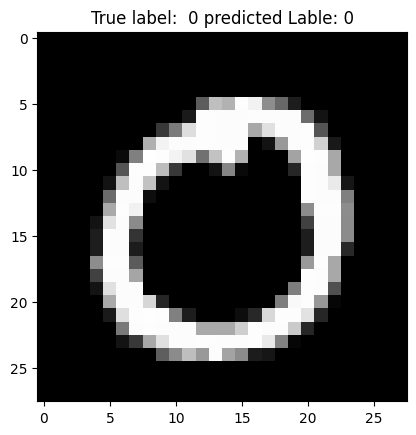

In [245]:
index = 50
test_image = x_train[:, index]
test_image = tf.reshape(test_image, shape=(-1, 1))
test_label = y_train[index]
y_pred = model(test_image)
predicted_label = tf.cast(y_pred >= 0.5, "int16")[0][0]

plt.title(f"True label:  {test_label} predicted Lable: {predicted_label}")
img = tf.reshape(test_image, shape=(28, 28)).numpy()
plt.imshow(img, cmap="gray")